# Tarea 1 - Redes Neuronales Convolucionales (CNNs)

## Parte 1: ResNet-50

In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.utils import plot_model

### Actividad 1

Estas capas de tamaño 1x1 son utilizadas para reducir/incrementar la dimensionalidad de los tensores. Antes de cada capa de 3x3, se coloca una de 1x1 para reducir las dimensiones y generar un cuello de botella en la capa de 3x3, de forma que el entrenamiento tarde menos. Posteriormente, se coloca otra de 1x1 para restaurar la dimensionalidad correspondiente a la etapa actual de la red.

### Actividad 2

En las redes profundas existe un problema conocido como degradación, que ocurre cuando presentan gran dificultad al momento de aprender funciones de identidad, que son fácilmente encontradas por redes normales. Una posible solución consiste en simular estas redes simples dentro de las profundas, haciendo uso de atajos que saltan algunas capas y luego se vuelven a unir con la salida de estas. Este modelo es conocido como los bloques residuales, debido a que en vez de intentar aprender funciones no lineales directamente, las capas intentan aproximar el residuo (diferencia) entre estas funciones y la de identidad. La gracia de esto es que ahora es posible aprender funciones tanto simples como complejas usando la misma red neuronal profunda.

### Actividad 3

Primero aplicamos las capas iniciales:

In [2]:
# Input layer
inputs = Input(shape=(224, 224, 3), name='input_layer')

# Initial layer + Max Pooling
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv_base_7x7')(inputs)
x = BatchNormalization(name='bn_conv_base')(x)
x = Activation('relu', name='relu_conv_base')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='max_pooling_base_3x3')(x)

A continuación se define una función que genera cada bloque residual para cada etapa de la red:

In [3]:
# Identity blocks
def identity_block(input_data, filters, block, stage):
    name_str = f'block_{block}_stage_{stage}'
    f1, f2, f3 = filters
    initial_stride = (1, 1)

    # Custom stride for 1st block (starting from stage 2)
    if stage > 1 and block == 1:
        initial_stride = (2, 2)
    
    # Block layers
    out = Conv2D(f1, (1, 1), strides=initial_stride, name='conv1_' + name_str + '_1x1')(input_data)
    out = BatchNormalization(name='bn1_' + name_str)(out)
    out = Activation('relu', name='relu_conv1_' + name_str)(out)
    out = Conv2D(f2, (3, 3), padding='same', name='conv2_' + name_str + '_3x3')(out)
    out = BatchNormalization(name='bn2_' + name_str)(out)
    out = Activation('relu', name='relu_conv2_' + name_str)(out)
    out = Conv2D(f3, (1, 1), name='conv3_' + name_str + '_1x1')(out)
    out = BatchNormalization(name='bn3_' + name_str)(out)
    if block == 1:  # Adapt dimensions for shortcut if needed
        input_data = Conv2D(f3, (1, 1), strides=initial_stride, name='conv_add_' + name_str + '_1x1')(input_data)
    
    # Add shortcut to output
    out = Add(name='add_' + name_str)([out, input_data])
    out = Activation('relu', name='relu_conv_add_' + name_str)(out)
    
    return out

Finalmente se utiliza la función anterior para aplicar la primera etapa de ResNet:

In [4]:
x = identity_block(x, [64, 64, 256], 1, 1)
x = identity_block(x, [64, 64, 256], 2, 1)
x = identity_block(x, [64, 64, 256], 3, 1)
print(x.shape)

(None, 56, 56, 256)


Obtenemos un tensor de 56x56x256.

### Actividad 4

Análogo a lo realizado anteriormente, podemos simular las etapas 2, 3 y 4 de la red:

In [5]:
x = identity_block(x, [128, 128, 512], 1, 2)
x = identity_block(x, [128, 128, 512], 2, 2)
x = identity_block(x, [128, 128, 512], 3, 2)
x = identity_block(x, [128, 128, 512], 4, 2)
print(x.shape)

(None, 28, 28, 512)


Al final de la etapa 2 tenemos un tensor de 28x28x512.

In [6]:
x = identity_block(x, [256, 256, 1024], 1, 3)
x = identity_block(x, [256, 256, 1024], 2, 3)
x = identity_block(x, [256, 256, 1024], 3, 3)
x = identity_block(x, [256, 256, 1024], 4, 3)
x = identity_block(x, [256, 256, 1024], 5, 3)
x = identity_block(x, [256, 256, 1024], 6, 3)
print(x.shape)

(None, 14, 14, 1024)


Al final de la etapa 3 tenemos un tensor de 14x14x1024.

In [7]:
x = identity_block(x, [512, 512, 2048], 1, 4)
x = identity_block(x, [512, 512, 2048], 2, 4)
x = identity_block(x, [512, 512, 2048], 3, 4)
print(x.shape)

(None, 7, 7, 2048)


Al final de la etapa 4 tenemos un tensor de 7x7x2048.

### Actividad 5

Tras terminar la secuencia de capas convolucionales, se aplica un Global Average Pooling para obtener un tensor de 1 dimensión, el que posteriormente se conecta a una capa densa de 1000 neuronas que utiliza SoftMax como función de activación (útil para clasificar):

In [8]:
x = GlobalAveragePooling2D(name='avg_pooling')(x)  # Flatten features using Global Avg Pooling method
x = Dense(1000, activation='softmax', name='fc_1000')(x)  # Fully connected layer
print(x.shape)

(None, 1000)


Notar que se redujo la dimensionalidad a simplemente 1000.

### Actividad 6

A continuación se tiene una función que permite recrear ResNet-50 utilizando lo explicado más arriba:

In [9]:
# Model for ResNet-50
def resnet_50():
    inputs = Input(shape=(224, 224, 3), name='input_layer')
    
    # BackBone
    net = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv_base_7x7')(inputs)
    net = BatchNormalization(name='bn_conv_base')(net)
    net = Activation('relu', name='relu_conv_base')(net)
    net = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='max_pooling_base_3x3')(net)
    stages = {1: 3, 2: 4, 3: 6, 4: 3}
    for stage in range(1, 5):
        factor = 2 ** (stage - 1)
        for block in range(1, stages[stage] + 1):
            net = identity_block(net, [64 * factor, 64 * factor, 256 * factor], block, stage)
    
    # Head
    net = GlobalAveragePooling2D(name='avg_pooling')(net)
    net = Dense(1000, activation='softmax', name='fc_1000')(net)
    model = Model(inputs, net)
    
    return model

La función comienza definiendo el tamaño del input y creando las capas iniciales. Luego realiza varias iteraciones en las que genera cada una de las etapas de la red, implementando los bloques residuales (BackBone). Posteriormente, se condensan las features con el Global Average Pooling y se pasa a una red densa que utiliza la función SoftMax para clasificar (Head). Finalmente se retorna el modelo para poder ser instanciado.

Instanciamos el modelo de la red. Al observar el resumen de las capas, es fácil verificar que los tamaños de cada tensor son los mismos obtenidos anteriormente:

In [10]:
resnet_model = resnet_50()
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_base_7x7 (Conv2D)          (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
bn_conv_base (BatchNormalizatio (None, 112, 112, 64) 256         conv_base_7x7[0][0]              
__________________________________________________________________________________________________
relu_conv_base (Activation)     (None, 112, 112, 64) 0           bn_conv_base[0][0]               
______________________________________________________________________________________________

Para terminar, se visualiza la arquitectura de ResNet-50 mediante el siguiente diagrama:

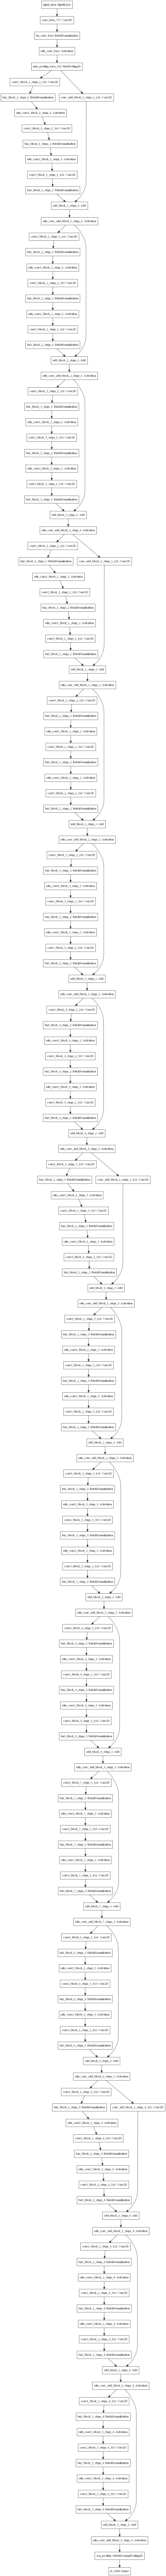

In [11]:
plot_model(resnet_model, 'ResNet-50.png')

## Parte 2: Análisis de Redes

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch import nn, optim
from tqdm import tqdm
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo.util import get_model_layers

# Use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load ResNet-50 model
resnet50 = models.resnet50(pretrained=True).to(device).eval()

### Actividad 7

In [38]:
get_model_layers(resnet50)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer1_0',
 'layer1_0_conv1',
 'layer1_0_bn1',
 'layer1_0_conv2',
 'layer1_0_bn2',
 'layer1_0_conv3',
 'layer1_0_bn3',
 'layer1_0_relu',
 'layer1_0_downsample',
 'layer1_0_downsample_0',
 'layer1_0_downsample_1',
 'layer1_1',
 'layer1_1_conv1',
 'layer1_1_bn1',
 'layer1_1_conv2',
 'layer1_1_bn2',
 'layer1_1_conv3',
 'layer1_1_bn3',
 'layer1_1_relu',
 'layer1_2',
 'layer1_2_conv1',
 'layer1_2_bn1',
 'layer1_2_conv2',
 'layer1_2_bn2',
 'layer1_2_conv3',
 'layer1_2_bn3',
 'layer1_2_relu',
 'layer2',
 'layer2_0',
 'layer2_0_conv1',
 'layer2_0_bn1',
 'layer2_0_conv2',
 'layer2_0_bn2',
 'layer2_0_conv3',
 'layer2_0_bn3',
 'layer2_0_relu',
 'layer2_0_downsample',
 'layer2_0_downsample_0',
 'layer2_0_downsample_1',
 'layer2_1',
 'layer2_1_conv1',
 'layer2_1_bn1',
 'layer2_1_conv2',
 'layer2_1_bn2',
 'layer2_1_conv3',
 'layer2_1_bn3',
 'layer2_1_relu',
 'layer2_2',
 'layer2_2_conv1',
 'layer2_2_bn1',
 'layer2_2_conv2',
 'layer2_2_bn2',
 'layer

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:07<00:00, 68.26it/s]



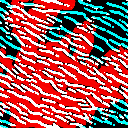

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:07<00:00, 67.86it/s]



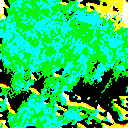

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:07<00:00, 65.29it/s]



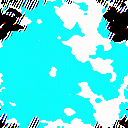

In [50]:
img = render.render_vis(resnet50, 'relu:0', show_inline=True)
img = render.render_vis(resnet50, 'relu:31', show_inline=True)
img = render.render_vis(resnet50, 'relu:63', show_inline=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:10<00:00, 51.10it/s]



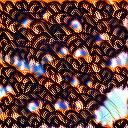

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:09<00:00, 51.44it/s]



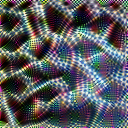

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:09<00:00, 51.33it/s]



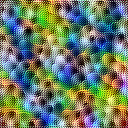

In [16]:
img = render.render_vis(resnet50, 'layer2_3_relu:0', show_inline=True)
img = render.render_vis(resnet50, 'layer2_3_relu:255', show_inline=True)
img = render.render_vis(resnet50, 'layer2_3_relu:511', show_inline=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:12<00:00, 40.61it/s]



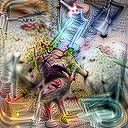

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:12<00:00, 40.76it/s]



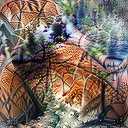

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:12<00:00, 40.60it/s]



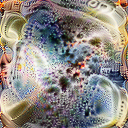

In [42]:
img = render.render_vis(resnet50, 'layer4_2_relu:0', show_inline=True)
img = render.render_vis(resnet50, 'layer4_2_relu:1023', show_inline=True)
img = render.render_vis(resnet50, 'layer4_2_relu:2047', show_inline=True)

### Actividad 8

In [2]:
# Message box
def print_msg_box(msg, indent=1, width=None, title=None):
    """Print message-box with optional title."""
    lines = msg.split('\n')
    space = ' ' * indent
    if not width:
        width = max(map(len, lines))
    box = f'╔{"═" * (width + indent * 2)}╗\n'  # upper_border
    if title:
        box += f'║{space}{title:<{width}}{space}║\n'  # title
        box += f'║{space}{"-" * len(title):<{width}}{space}║\n'  # underscore
    box += ''.join([f'║{space}{line:<{width}}{space}║\n' for line in lines])
    box += f'╚{"═" * (width + indent * 2)}╝'  # lower_border
    print(box)

# Load model (ResNet-50)
def get_model(n_classes, pretrained=None):
    model = models.resnet50(pretrained=pretrained)
    model.fc = nn.Linear(in_features=2048, out_features=n_classes, bias=True)
    model.to(device)
    return model

# Run an epoch with the model
def run_epoch(phase, model, loader, criterion, optimizer=None, epoch=0, total_epoch=0):
    n_batches = len(loader)
    if phase == 'train':
        model.train()
    elif phase == 'val' or 'test':
        model.eval()
    agg_loss = 0.0
    agg_acc = 0.0
    with tqdm(loader, unit='batch', position=0, leave=True) as tepoch:
        for n_batch, (x, y) in enumerate(tepoch, start=1):
            if phase == 'train': # Clean gradients on training
                optimizer.zero_grad()
                tepoch.set_description(f'Epoch {epoch}/{total_epoch}')
            elif phase == 'val':
                tepoch.set_description('Validating')
            x = x.to(device)
            y = y.to(device)
            result = model(x) # Execute model
            loss = criterion(result, y) # Loss calculation
            agg_loss += loss.item()
            _, preds = torch.max(result, 1) # Prediction
            agg_acc += torch.sum(preds == y.data)
            if phase == 'train':
                loss.backward() # Backpropagation only while training
                optimizer.step() # Update weights only while training
            current_agg_loss = agg_loss / n_batch
            current_agg_acc = agg_acc / (n_batch * batch_size)
            tepoch.set_postfix(Loss=current_agg_loss, Acc=current_agg_acc.item())
    epoch_loss = float(agg_loss / n_batch)
    epoch_acc = float(agg_acc / (n_batch * batch_size))
    return epoch_loss, epoch_acc

# Execute training with the model
def run_training(model, train_loader, val_loader, optimizer, criterion, n_epochs):
    history = {
        'training': {'loss': [], 'acc': []},
        'validation': {'loss': [], 'acc': []}
    }

    for epoch in range(1, n_epochs + 1):
        train_epoch_loss, train_epoch_acc = run_epoch('train', model, train_loader, criterion, optimizer=optimizer, epoch=epoch, total_epoch=n_epochs)
        val_epoch_loss, val_epoch_acc = run_epoch('val', model, val_loader, criterion, optimizer=optimizer, epoch=epoch, total_epoch=n_epochs)
        # Save loss/accuracy values for each epoch
        history['training']['loss'].append(train_epoch_loss)
        history['training']['acc'].append(train_epoch_acc)
        history['validation']['loss'].append(val_epoch_loss)
        history['validation']['acc'].append(val_epoch_acc)
    return history

# Execute testing with the model
def run_testing(model, loader, criterion):
    test_loss, test_acc = run_epoch('test', model, loader, criterion)
    print()
    print_msg_box(f'\nTest loss: {test_loss:.4f}, Test acc.: {test_acc:.2f}\n', indent=5)
    return {'loss': test_loss, 'acc': test_acc}

In [3]:
import flowers_dataset.flowers as f

# Preprocessing
transform = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Adjust batch size
batch_size = 32

# Load flowers training set
trainset = f.Flowers('flowers_dataset/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Load flowers validation set
valset = f.Flowers('flowers_dataset/val/', transform=transform)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

# Load flowers testing set
testset = f.Flowers('flowers_dataset/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [4]:
# Train model
model = get_model(102, True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

run_training(model, train_loader, val_loader, optimizer, criterion, 20)

Epoch 4/20:  34%|███████████████████████████▋                                                      | 60/178 [00:17<00:34,  3.40batch/s, Acc=0.963, Loss=0.396]


KeyboardInterrupt: 

### Actividad 9

##  Parte 3: Detección de Objetos